In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os


import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

In [2]:
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
from easy_transformer.experiments import (
    ExperimentMetric,
    AblationConfig,
    EasyAblation,
    EasyPatching,
    PatchingConfig,
)

### SOLU: Softmax Linear Units
Here we'll study a transformer trained with the [softmax linear unit](https://transformer-circuits.pub/2022/solu/index.html)

In [4]:
device = "cuda"

In [5]:
model_name = "solu-8l-old"
model = EasyTransformer.from_pretrained(model_name).to(device)

Loading model: solu-8l-old


Using pad_token, but it is not set yet.


Moving model to device:  cuda
Finished loading pretrained model solu-8l-old into EasyTransformer!
Moving model to device:  cuda


In [65]:
model.cfg

EasyTransformerConfig:
{'act_fn': 'solu_ln',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 4096,
 'd_model': 1024,
 'd_vocab': 50278,
 'd_vocab_out': 50278,
 'device': 'cuda',
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.025,
 'model_name': 'SoLU_8L_v21_old',
 'n_ctx': 1024,
 'n_heads': 16,
 'n_layers': 8,
 'n_params': 100663296,
 'normalization_type': 'LNPre',
 'original_architecture': 'neel-solu-old',
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': 42,
 'tokenizer_name': 'EleutherAI/gpt-neox-20b',
 'use_attn_result': False,
 'use_attn_scale': True,
 'use_local_attn': False,
 'window_size': None}

### Induction heads
We look for induction heads by feeding in a random sequence of tokens repeated twice and looking for heads that attend from a second copy of a token to the token just after the first copy.

In [6]:
seq_len = 100
rand_tokens = torch.randint(1000, 10000, (4, seq_len))
rand_tokens_repeat = einops.repeat(rand_tokens, "batch pos -> batch (2 pos)").to(device)

In [45]:
## Mask out the heads with the highest induction score
induction_scores_array = np.zeros((model.cfg.n_layers, model.cfg.n_heads))

def calc_induction_score(attn_pattern, hook):
    """Pattern has shape [batch, index, query_pos, key_pos]
    """
    induction_stripe = attn_pattern.diagonal(1 - seq_len, dim1=-2, dim2=-1)
    induction_scores = einops.reduce(
        induction_stripe, "batch index pos -> index", "mean"
    )
    # store these in a common array
    induction_scores_array[hook.layer()] = induction_scores.detach().cpu().numpy()
    

In [9]:
def filter_attn_hooks(hook_name):
    split_name = hook_name.split(".")
    return split_name[-1] == "hook_attn"

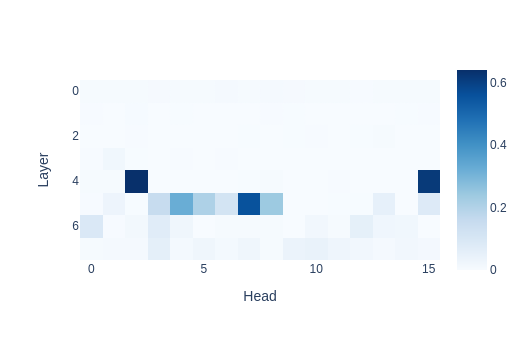

In [56]:
induction_logits = model.run_with_hooks(
    rand_tokens_repeat, fwd_hooks=[(filter_attn_hooks, calc_induction_score)]
)
px.imshow(induction_scores_array,
          labels={"y": "Layer", "x": "Head"},
          color_continuous_scale="Blues",
         )

It appears that the max score for the random tokens is around 0.6. Above that threshold there appear to be two attention heads `L4H2` with score 0.6402724, and `L4H15` with score 0.6168649. A third attention head is slightly less activated, `L5H7`, with score 0.5587158. Is this an induction head, or some other kind of attention head?

**Validation**: We can ablate the top few heads by the metric defined by `calculate_induction_score`, and show that performance drops substantially.

In [57]:
thresh_score = 0.5

In [58]:
induction_logits = model(rand_tokens_repeat)
induction_log_probs = F.log_softmax(induction_logits, dim=-1)
induction_pred_log_probs = torch.gather(
    induction_log_probs[:, :-1], -1, rand_tokens_repeat[:, 1:, None]
)[..., 0]

In [64]:
# The chart above seems pretty sparse so we print this to see what the attention mask might look like after pruning
induction_scores_array > thresh_score

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, Fals

In [60]:
# mask out the heads with the highest induction score
attn_head_mask = induction_scores_array > thresh_score

def prune_attn_heads(value, hook):
    """Value has shape [batch, pos, index, d_head]
    """
    mask = attn_head_mask[hook.layer()]
    value[:, :, mask] = 0.0
    return value

def filter_value_hooks(name):
    return name.split(".")[-1] == "hook_v"

Original loss on repeated sequence: -6.096261024475098
Loss on repeated sequence without induction heads: -9.745206832885742


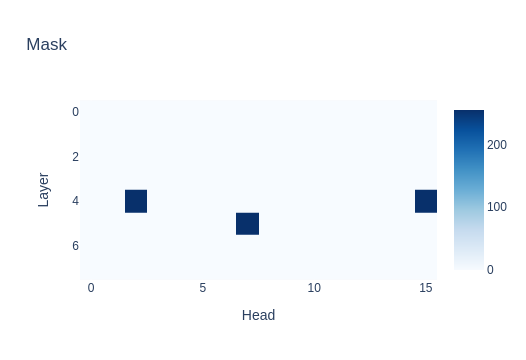

In [61]:
ablated_logits = model.run_with_hooks(
    rand_tokens_repeat, fwd_hooks=[(filter_value_hooks, prune_attn_heads)]
)
ablated_log_probs = F.log_softmax(ablated_logits, dim=-1)
ablated_pred_log_probs = torch.gather(
    ablated_log_probs[:, :-1], -1, rand_tokens_repeat[:, 1:, None]
)[..., 0]
print(
    "Original loss on repeated sequence:", induction_pred_log_probs[:, seq_len:].mean().item()
)
print(
    "Loss on repeated sequence without induction heads:",
    ablated_pred_log_probs[:, seq_len:].mean().item(),
)
px.imshow(
    attn_head_mask,
    labels={"y": "Layer", "x": "Head"},
    color_continuous_scale="Blues",
    title="Mask",
)

A threshold of 0.5 gives us 3 heads and drops performance in the following way:

>Original loss on repeated sequence: -6.096261024475098

>Loss on repeated sequence without induction heads: -9.745206832885742

A threshold of 0.6 gives us two heads, with the following loss:
>Original loss on repeated sequence: -6.096261024475098

>Loss on repeated sequence without induction heads: -8.345271110534668

### Ablating heads that mostly attend to the previous token

Long text: we have two runs with two different prompts and different answers, eg 'Steve Jobs founded' -> ' Apple' and 'Bill Gates founded' -> 'Microsoft'. We patch parts of the layer outputs or residual stream from specific tokens and positions and see which patches significantly shift the answer from 'Apple' to 'Microsoft'


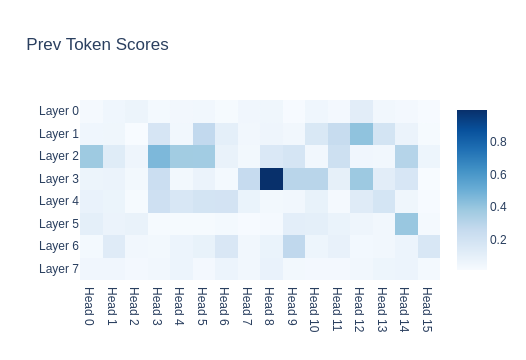

In [67]:
long_text = "we have two runs with two different prompts and different answers, eg 'Steve Jobs founded' -> ' Apple' and 'Bill Gates founded' -> 'Microsoft'. We patch parts of the layer outputs or residual stream from specific tokens and positions and see which patches significantly shift the answer from 'Apple' to 'Microsoft'"
print("Long text:", long_text)
attn_cache = {}

def filter_hook_attn(name):
    split_name = name.split(".")
    return split_name[-1] == "hook_attn"

def cache_attn(attn, hook):
    attn_cache[hook.name] = attn

logits = model.run_with_hooks(long_text, fwd_hooks=[(filter_hook_attn, cache_attn)])

# we go through the cache and find the avg attention paid to previous tokens
prev_token_scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        attn = attn_cache[f"blocks.{layer}.attn.hook_attn"][0, head]
        prev_token_scores[layer, head] = attn.diag(-1).mean().item()

px.imshow(
    prev_token_scores,
    x=[f"Head {hi}" for hi in range(model.cfg.n_heads)],
    y=[f"Layer {i}" for i in range(model.cfg.n_layers)],
    title="Prev Token Scores",
    color_continuous_scale="Blues",
)

We identify Head 8, Layer 3 as mostly responsible for identifying the previous token.
Future work: Find the effect of pruning that head

In [68]:
# pruning the "previous token head"
layer = 3
head_indices = torch.tensor([8])

def prune_attn_heads(value, hook):
    """Value has shape [batch, pos, index, d_head]
    """
    value[:, :, head_indices, :] = 0.0
    return value

def filter_value_hooks(name):
    return name.split(".")[-1] == "hook_v"

In [77]:
ablation_logits = model.run_with_hooks(long_text, fwd_hooks=[(filter_value_hooks, prune_attn_heads)])
ablation_log_probs = F.log_softmax(ablation_logits, dim=-1)
text_token_ids = model.tokenizer.encode(long_text)
ablated_pred_log_probs = torch.gather(
    ablated_log_probs[:, :-1], -1, [[text_token_ids]][:, 1:, None]
)[..., 0]

<>:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

<>:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

/tmp/ipykernel_137162/3350977072.py:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

/tmp/ipykernel_137162/3350977072.py:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

/tmp/ipykernel_137162/3350977072.py:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

/tmp/ipykernel_137162/3350977072.py:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

/tmp/ipykernel_137162/3350977072.py:5: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?



TypeError: list indices must be integers or slices, not tuple

In [ ]:
print(
    "Original loss on repeated sequence:", induction_pred_log_probs[:, seq_len:].mean().item()
)
print(
    "Loss on repeated sequence without induction heads:",
    ablated_pred_log_probs[:, seq_len:].mean().item(),
)

[664,
 452,
 767,
 6613,
 342,
 767,
 1027,
 49887,
 285,
 1027,
 9172,
 13,
 24088,
 686,
 31969,
 32254,
 11420,
 8,
 5204,
 686,
 8217,
 8,
 285,
 686,
 25310,
 27982,
 11420,
 8,
 5204,
 686,
 16880,
 5983,
 844,
 12097,
 4243,
 273,
 253,
 3828,
 18012,
 390,
 12541,
 5542,
 432,
 2173,
 21761,
 285,
 6887,
 285,
 923,
 534,
 20412,
 3012,
 5333,
 253,
 3662,
 432,
 686,
 25989,
 8,
 281,
 686,
 16880,
 8]